### Assignment 1

In [9]:
# import sys
# !{sys.executable} -m pip install numpy
# import os
# print("Current working directory: ", os.getcwd())

In [10]:
# Import the necessary libraries/packages here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# import math

### Helpful Notes:
1. Dataset 1: a linearly separable dataset where you can test the correctness of your base learner and boosting algorithms
   
   300 samples 2 features
   
   ![dataset1.png](./dataset1.png)
   
   Generally speaking, your learners shall 100% correctly classify the data in dataset 1.

2. Dataset 2 ~ 4 : non-linearly separable cases, applying descent boosting techniques can be beneficial
   
   Dataset 2: 300 samples 2 features. In comparison to the performance of your single base learner, does your boosting algorithm perferm better?
      
   ![dataset2.png](./dataset2.png)
      
   Dataset 3: 400 samples 2 features (challenging)

      A good classifier shall obtain a ellipse-like decision boundary on this dataset. Can your algorithms handle this dataset? If not, can you try to give reasonable explanations?

   ![dataset3.png](./dataset3.png)

   Dataset 4: 3000 samples 10 features (more challenging)
   
      This is more or less the higher dimensional version of dataset3. We visualize the first two features of dataset 3, As it is shown in the following figure, they are non-linearly separable. 
      
      How do your algorithms perform?

   ![dataset4.png](./dataset4.png)

   
3. The data is also provided in csv format:
   1. Feature columns and a label column 
   
HINTs: 
1. Split the data into two parts (i.e., training data and test data).
2. Draw decision boundary (surface) of your classifiers (on dataset 1 & 2) can be helpful.
3. Carefully design your experiments so that you can understand the influence of increasing or decreasing some parameters (e.g., learning rate, number of base learners in boosting Alg.)
4. Make smart implementations (e.g., vectorization using numpy to avoid some nested-loops in python), so that you can efficiently run more experiments
5. The performance of your classifiers is not of high priority in this assignment.
   1. The datasets are all artificially generated (toy) data, in principle, there is no need to preprocess the data.
   2. Constructive discussions on your findings are more important. If the results are not good, try to find out the reasons.
   3. We hope this assignment can help you fill in the gap between theory and application.
6. You are encouraged to implement not only Adaboost but also other boosting algorithms of your choice.

In [11]:
""" Load the dataset
Dataset (Numpy npz file)
|- features (Numpy.ndarray)
|- labels (Numpy.ndarray)

The data is also provided in csv format.
"""

def load_data(file_name='dataset1.npz'):
    """ Load the Numpy npz format dataset 
    Args:
        file_name (string): name and path to the dataset (dataset1.npz, dataset2.npz, dataset3.npz)
    Returns:
        X (Numpy.ndarray): features
        y (Numpy.ndarray): 1D labels
    """
    import numpy as np
    data = np.load(file_name)
    X, y = data['features'], data['labels']
    return X, y

# Load dataset 1 by default
X, y =load_data()
print(X.shape)
print(y.shape)


(300, 2)
(300,)


### Skeleton codes:
You should follow the structure of this code:

In [12]:
class Perceptron:
    # Implement your base learner here
    def __init__(self, learning_rate=0.4, max_iter=5, **kwargs):
        """ Initialize the parameters here 
        Args:
            learning_rate (float or a collection of floats): your learning rate
            max_iter (int): the maximum number of training iterations
            Other parameters of your choice
        
        Examples ToDos:
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        Try different initialization strategies (as required in Question 2.3)
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
       
    
        pass
    
    

    def fit(self, X, y, **kwargs):
        """ Implement the training strategy here
        Args:
            X (Numpy.ndarray, list, etc.): The training data
            y (Numpy.ndarray, list, etc.): The labels
            Other parameters of your choice

        Example ToDos:
        # for _ in range(self.max_iter):
        #     Update the parameters of Perceptron according to the learning rate (self.learning_rate) and data (X, y)
        """  
        
        self.coef_ = np.random.normal(loc=0.0, scale=0.01, size=(1 + X.shape[1]))
        
        self.errors_ = []
        for _ in range(self.max_iter):
            errors = 0
            self.learning_rate = self.learning_rate * 0.5
            
            for xi, expected_value in zip(X, y):
                predicted_value = self.predict(xi)
                self.coef_[1:] = self.coef_[1:] + self.learning_rate * (expected_value - predicted_value) * xi
                self.coef_[0] = self.coef_[0] + self.learning_rate * (expected_value - predicted_value) * 1
                update = self.learning_rate * (expected_value - predicted_value)
                errors += int(update != 0.0) 
            self.errors_.append(errors)
            
       
        pass
            
    def net_input(self, X):
        weighted_sum = np.dot(X,self.coef_[1:]) + self.coef_[0]
        return weighted_sum

    def activation_function(self, X):
        weighted_sum = self.net_input(X)
        return np.where(weighted_sum >= 0.0, 1, -1)

    def predict(self, x, **kwargs):
        """ Implement the prediction strategy here
        Args:
            x (Numpy.ndarray, list, Numpy.array, etc.): The input data
            Other parameters of your choice
        Return(s):
            The prediction value(s), namely, class label(s), others of your choice
        """ 
        return self.activation_function(x)

    def score(self, X, y):
        misclassified_data_count = 0
        for xi, target in zip(X, y):
            output = self.predict(xi)
            if(target != output):
                misclassified_data_count += 1
        total_data_count = len(X)
        self.score_ = (total_data_count - misclassified_data_count)/total_data_count
        return self.score_

In [13]:
# Compute error rate, alpha and w
def compute_error(y, preds, d_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation
    
    Note that all arrays should be the same length
    '''
    
    return sum(d_i * (np.not_equal(y, preds)).astype(int))/sum(d_i)

def compute_alpha(min_error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    EPS=1e-10
    return np.log((1 - min_error+EPS) / (min_error + EPS))

def update_distribution(d_i, alpha, y, preds, min_error):
    ''' 
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    EPS=1e-10
    return d_i * np.exp(alpha*(np.not_equal(y, preds)))
    

In [14]:
# Define AdaBoost class
class AdaBoost:
    
    def __init__(self, n_estimators, **kwargs):
        self.n_estimators = n_estimators
        self.alphas = []
        self.G_M = []
        self.M = None

    def fit(self, X, y, **kwargs):

        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        M = self.n_estimators
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if len(self.alphas) == 0:
                d_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                d_i = update_distribution(d_i, alpha_m, y, preds, error_m)

            G_m = Perceptron()          
            # (a) Fit weak classifier and predict labels 
            G_m.fit(X, y)
            
            preds = G_m.predict(X)
            # print(preds)
            self.G_M.append(G_m) # Save to list of weak classifiers
           

            # (b) Compute error
            error_m = compute_error(y, preds, d_i)
            
            
            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            

        assert len(self.G_M) == len(self.alphas)
        return self.alphas

    def predict(self,X, alpha_m):
        clf_preds = [alpha_m[i] * G_m.predict(X) for i, G_m in enumerate(self.G_M)]
        y_pred = np.sum(clf_preds,axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

    

In [15]:
def run(**kwargs):
    """ Single run of your classifier
    # Load the data
    X, y = load_data()
    # Find a way to split the data into training and test sets
    -> X_train, y_train, X_test, y_test
    
    # Initialize the classifier
    base = Perceptron("your parameters")
    
    # Train the classifier
    base.fit(X_train, y_train, "other parameters")
   
    # Test and score the base learner using the test data

    y_pred = base.predict(X_test, "other parameters")
    score = SCORING(y_pred, y_test)
    """
    np.random.seed(1)
    X, y =load_data()
    
    # Create training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


    

    prcptrn = Perceptron()
    prcptrn.fit(X_train, y_train)
   

    print('Accuracy test: ',prcptrn.score(X_test, y_test),'Accuracy train: ', prcptrn.score(X_train, y_train))


    %matplotlib inline
    import matplotlib.pyplot as plt
 
    plt.plot(range(1, len(prcptrn.errors_) + 1), prcptrn.errors_, marker='o')
    plt.xlabel('Epochs')
    plt.xscale('log')
    plt.ylabel('Number of updates')
    
    plt.show()

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
   

    ada_boost = AdaBoost(n_estimators=600)

    alpha_m = ada_boost.fit(X_train, y_train)
    y_pred_test = ada_boost.predict(X_test, alpha_m)
    y_pred_train = ada_boost.predict(X_train, alpha_m)

   
    print('---------------------------------------------------------------------------------------')
    print('Accuracy test: ',accuracy(y_test, y_pred_test),'Accuracy train: ', accuracy(y_train, y_pred_train))

    %matplotlib inline
    import matplotlib.pyplot as plt
 
    plt.plot(alpha_m)
    plt.xlabel('Iterations of the weak classifier')
    plt.ylabel('Alpha')
    plt.title('Alpha over the EPOCHS')
    
    plt.show()


    pass


Accuracy test:  1.0 Accuracy train:  1.0


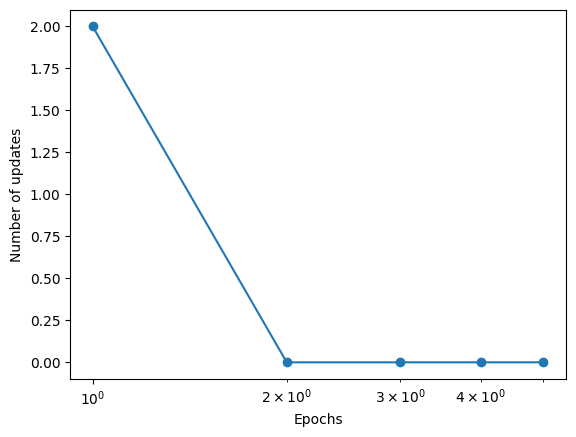

---------------------------------------------------------------------------------------
Accuracy test:  1.0 Accuracy train:  1.0


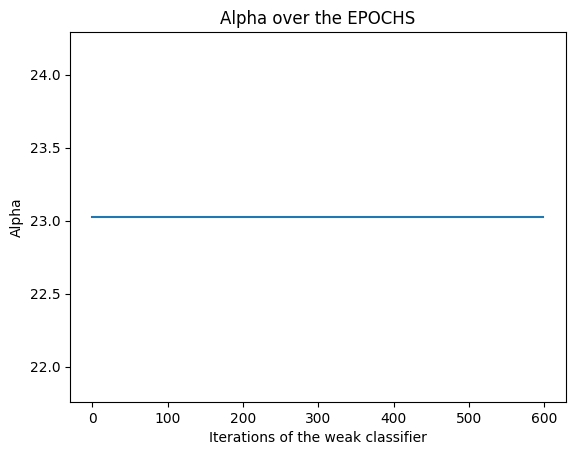

In [16]:
run()

Good luck with the assignment